# Week 5 Part 2 Assignment
### DATA 620<br>David Moste &emsp; Euclid zhang &emsp; Samuel Reeves  <br>6/27/2021

Presentation Video Link: To Be Done

In [1]:
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from bs4 import BeautifulSoup

### Data Description

Data source: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

Our data contains a set of fake and real news

### Data Preparation

In [2]:
fake_news = pd.read_csv(r"Fake.csv", header=0, index_col=False)
real_news = pd.read_csv(r"True.csv", header=0, index_col=False)

Add the column variable indicating the news is fake or not

In [3]:
fake_news['fake'] = True
real_news['fake'] = False

In [4]:
fake_news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",True
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",True
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",True
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",True
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",True


Number of fake news and number of real news:

In [5]:
len(fake_news), len(real_news)

(23481, 21417)

There are too many news items! we will select a small subset for our analysis.

For example, a set of news with category 'politices' and with Trump mentioned in the news

In [6]:
fake_news2 = fake_news.loc[fake_news['subject'] == 'politics']
real_news2 = real_news.loc[fake_news['subject'] == 'politics']

In [7]:
fake_news2 = fake_news2.loc[[bool(re.search('[t|T]rump',news)) for news in fake_news2['text']]]
real_news2 = real_news2.loc[[bool(re.search('[t|T]rump',news)) for news in real_news2['text']]]

In [8]:
len(fake_news2), len(real_news2)

(3073, 1653)

Combine the fake news and real news into one data frame

In [9]:
news = fake_news2[['text','fake']].append(real_news2[['text','fake']], ignore_index = True)

#complete list of all news
#news = fake_news[['text','real_news']].append(real_news[['text','real_news']], ignore_index = True)

Let's check the first news and see what we should do to clean up the text

In [10]:
fake_news['text'][0]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev

The following will need to be handled: <br>
1. spacing between numbers and letters
2. removing numbers
3. removing special characters except the '.' character used for abbreviations
4. remove hyper links
5. remove html markups (since hyper links is showed, there may be texts with html markups)
6. remove stop words
7. The ' character is ommitted. For example, ' is missing in "he s", we will convert it back to "he is"
8. The string "Images." at the end of the text is used to represent that there are images attached to the news. We will remove the string
9. stemming and lemmatizing

Create stemmer and lemmatizer. Generate a list of stop words

In [14]:
porter = nltk.PorterStemmer()
wnl = nltk.WordNetLemmatizer()
nltk.download('stopwords')
stop_words = stopwords.words('english')
#add extra stop words that is not included in the stop words list
#'' is used to remove empty word
stop_words = stop_words + ['could', 'should','would','']
#keep the word 'not' in the text since negation may have meanings here
stop_words.remove('not')

[nltk_data] Downloading package stopwords to /home/s/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Set up a function to perform text cleaning as described above

In [15]:
def clean_text(text):
    
    #convert to lower case
    text = str(text).lower()   
    
    #remove hyperlinks
    text = re.sub(r'[^\s]+\.com.[^\s]+','',text)
    text = re.sub(r'http[^\s]+','',text)
    
    #clean the html markups
    text = BeautifulSoup(text).get_text()
    
    #A lot of the news have the word 'images' at the end to represent that 
    #there are images attached to the news. We will remove such words
    text = re.sub(r'Images\.$', '', text)
    
    #remove special characters except '.', since it can be used in abbreviations (F.B.I. for example)
    text = re.sub(r'[^A-Za-z\s\.]+', ' ', text)  
    #remove '.' that is not used in abbreviations
    text = re.sub(r'([A-Za-z]{2,})\.', r'\1 ', text)
    
    
    #replace multiple spaces by 1 space
    text = re.sub(r'\s{2,}', ' ', text)
       
    #in the text, the ' character is omiited. Therefore, string such as he's is stored as he s
    #the following codes covert such string to its complete form. For example, he'll is coverted into he will
    text = re.sub(r'(he|she|it|this|that) (s )', r'\1 is', text)
    text = re.sub(r'(they|we) (re)', r'\1 are', text)
    text = re.sub(' ve ', ' have ', text)
    text = re.sub(' ll ', ' will ', text)
    text = re.sub('won t ', 'will not ', text)
    text = re.sub('n t ', ' not ', text)
    
    #split the text into words and filter out stop words
    text = [word for word in text.split(' ') if word not in stop_words]
    #text stemming
    text = [porter.stem(word) for word in text]
    #text lemmatizing
    text = [wnl.lemmatize(word) for word in text]
   
    #convert the words back to one string
    text = " ".join(text)
    #remove spaces from start and end of string
    text = text.strip()
    
    return text

Clean up all texts

In [17]:
nltk.download('wordnet')
news['cleaned_text'] = news['text'].apply(clean_text)

[nltk_data] Downloading package wordnet to /home/s/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Check if there are any documents with empty content after text clean up

In [18]:
news.loc[[len(news) == 0 for news in news['cleaned_text']]]['text']

3066    https://100percentfedup.com/video-hillary-aske...
Name: text, dtype: object

Documents with only a hyper link as content will become an empty string after clean up

Remove documents with empty content after text clean up

In [19]:
news = news.loc[[len(news) != 0 for news in news['cleaned_text']]]
news.reset_index(drop=True, inplace = True)

In [20]:
news

,text,fake,cleaned_text
0,Just one more reminder of why President Trump ...,True,one remind presid trump chose nonsens gener jo...
1,Thank goodnesss Jeff Sessions is moving on fin...,True,thank goodness jeff session move find went beh...
2,The GOP presidential candidate who couldn t se...,True,gop presidenti candid not seem find spine perf...
3,John Podesta is Hillary Clinton s former campa...,True,john podesta hillari clinton former campaign c...
4,EAG News A Wyoming high school is under fire ...,True,eag news wyom high school fire parent expo onl...
...,...,...,...
4720,SEOUL (Reuters) - North Korea may be planning ...,False,seoul reuter north korea may plan new missil t...
4721,SEOUL/BEIJING (Reuters) - Chinese President Xi...,False,seoul beij reuter chine presid xi jinp repli n...
4722,(Reuters) - The White House admonished Russia ...,False,reuter white hous admonish russia wednesday ve...
4723,HONG KONG (Reuters) - Hong Kong will try to en...,False,hong kong reuter hong kong tri enact law penal...


In [ ]:
#news.to_csv(r"E:\SPS\DATA 620\assignments\data\fake and real news\news.csv", index = False)

In [ ]:
#news = pd.read_csv(r"E:\SPS\DATA 620\assignments\data\fake and real news\news.csv", header=0, index_col=False)

### Analysis

Use TfidfVectorizer to calculate the Term Frequency — Inverse Document Frequency of unigram tokens

In [21]:
Tf_Idf_Vectorizer = TfidfVectorizer(ngram_range=(1,1))

In [22]:
X = Tf_Idf_Vectorizer.fit_transform(news['cleaned_text']).toarray()
Y = news['fake']

In [23]:
df_tfidfvect = pd.DataFrame(data = X,columns = Tf_Idf_Vectorizer.get_feature_names())

In [24]:
df_tfidfvect

,aaa,aadl,aapl,aardvark,aarhu,aaron,aaronapollocamp,aarondfordnv,aarp,ab,...,ztqxcz,zucker,zuckerberg,zuckerman,zuckersaid,zuhri,zullo,zuma,zwgrt,zyuganov
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Separate the TF-IDF data frame into one with fake news and one with real news

In [25]:
df_tfidfvect_real = df_tfidfvect.loc[news['fake'] == False]

In [26]:
df_tfidfvect_fake = df_tfidfvect.loc[news['fake']]

The most important key words mentioned in real news (excluding Trump since we selected our subset by the key word 'Trump') are:

In [27]:
most_important_real = df_tfidfvect_real.sum().sort_values(ascending = False).T.drop('trump')
most_important_real[:20]

said           129.016760
republican      78.017812
state           68.189751
reuter          63.491731
not             53.544606
jerusalem       51.355068
korea           47.992599
cruz            47.583278
presid          47.443433
north           46.503688
unit            45.999406
presidenti      45.874973
israel          45.858149
parti           44.132577
clinton         40.902743
campaign        39.055905
candid          37.588130
palestinian     37.382781
nomin           36.821695
senat           36.169973
dtype: float64

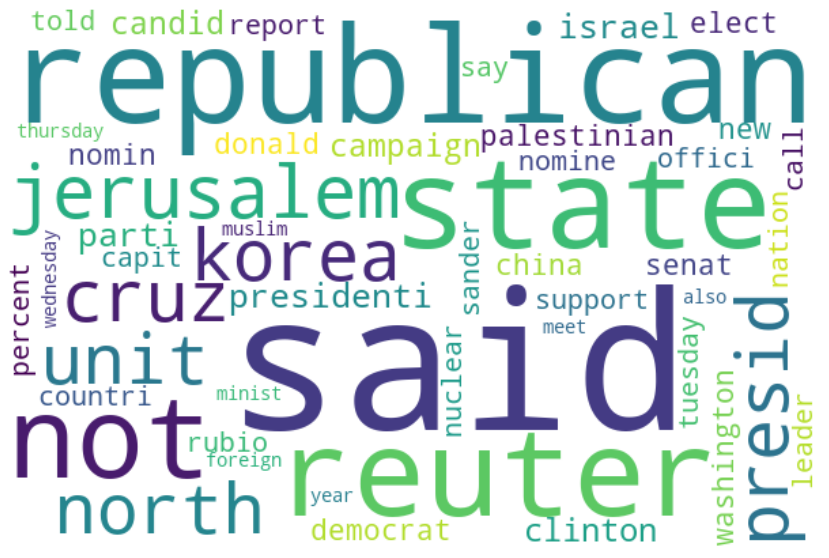

In [29]:
import wordcloud
from wordcloud import WordCloud
Cloud = WordCloud(width=600, height=400, background_color="white", max_words=50).generate_from_frequencies(most_important_real)
plt.figure(figsize = (15,10))
plt.imshow(Cloud, interpolation ='bilinear')
plt.axis('off')
plt.show()

The most important key words mentioned in fake news (excluding Trump since we selected our subset by the key word 'Trump') are:

In [30]:
most_important_fake = df_tfidfvect_fake.sum().sort_values(ascending = False).T.drop('trump')
most_important_fake[:20]

not         123.638472
presid       89.359200
clinton      69.766304
said         69.504908
hillari      64.867057
obama        64.548276
peopl        57.010919
american     51.366675
donald       50.776834
support      49.894581
one          48.224207
say          47.568663
democrat     47.076994
news         46.442399
like         46.320346
elect        44.539405
go           44.444287
state        43.346123
report       43.193090
vote         42.968587
dtype: float64

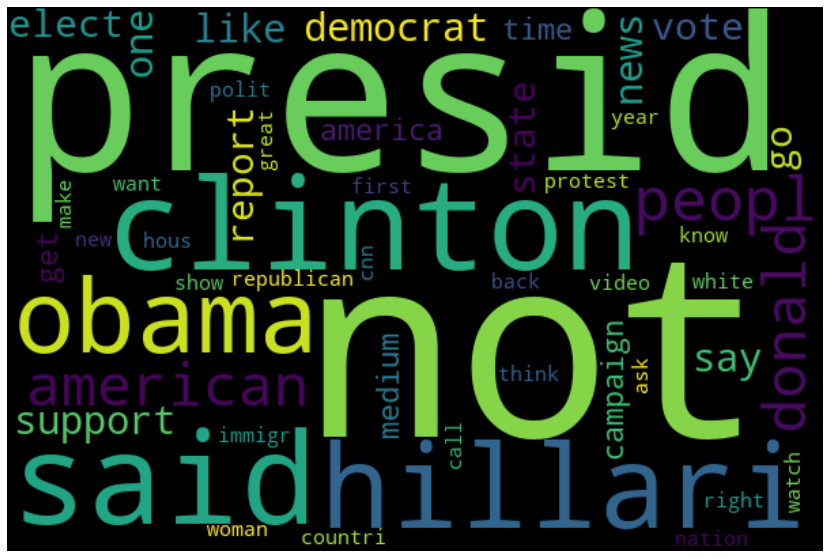

In [31]:
import wordcloud
from wordcloud import WordCloud
Cloud = WordCloud(width=600, height=400, background_color="black", max_words=50).generate_from_frequencies(most_important_fake)
plt.figure(figsize = (15,10))
plt.imshow(Cloud, interpolation ='bilinear')
plt.axis('off')
plt.show()

It's interesting to see that a lot of key words about real news are about republicans and a lot of key words about fake news are democrats. The politics news are really politics.

Now let's build our model using Multinomial Naive Bayes

In [32]:
mnb = MultinomialNB()

We will perform cross validation and generate a list of performance scores

In [33]:
model_scores = pd.DataFrame(columns = ['accurary','precision','recall','F1',
                                       'True Positive','False Positive','True Negative','False Negative'])
kf = KFold(n_splits=5,random_state=620,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    mnb.fit(X_train, Y_train)
    y_pred = mnb.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test, y_pred)
    precision = metrics.precision_score(Y_test, y_pred)
    recall = metrics.recall_score(Y_test, y_pred)
    F1 = metrics.f1_score(Y_test, y_pred)
    cm = metrics.confusion_matrix(Y_test, y_pred)
    cm = cm/cm.astype(np.float).sum(axis=0)
    model_scores.loc[len(model_scores)] = [accuracy,precision,recall,F1,cm[1, 1],cm[0, 1],cm[0, 0],cm[1, 0]]
    
model_scores.loc['Average'] = model_scores.mean()

model_scores

/tmp/ipykernel_25544/3370054597.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm/cm.astype(np.float).sum(axis=0)
/tmp/ipykernel_25544/3370054597.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm/cm.astype(np.float).sum(axis=0)
/tmp/ipykernel_25544/3370054597.py:15: DeprecationWarning: `np.float` is a deprecated alia

,accurary,precision,recall,F1,True Positive,False Positive,True Negative,False Negative
0,0.896296,0.870185,0.988655,0.925645,0.870185,0.129815,0.971311,0.028689
1,0.881481,0.851095,0.983137,0.912363,0.851095,0.148905,0.961538,0.038462
2,0.918519,0.895678,0.988487,0.939797,0.895678,0.104322,0.974453,0.025547
3,0.876190,0.849083,0.983660,0.911431,0.849083,0.150917,0.957627,0.042373
4,0.904762,0.895415,0.973520,0.932836,0.895415,0.104585,0.931174,0.068826
Average,0.895450,0.872291,0.983492,0.924414,0.872291,0.127709,0.959221,0.040779


The scores are indicating that our model is performing well. The accurary is around 90 percent. We have correctly identified 87% of the fake news and 96% of the real news